In [2]:
import numpy as np
import pandas as pd
import gym
from gym import spaces

class StockEnv(gym.Env):
    def __init__(self, df, initial_capital=100000, buy_min=0.44, buy_max=0.57, 
                 sell_min=0.35, sell_max=0.84, transaction_session=10, 
                 transaction_penalty=150, transaction_fee=0.005, 
                 total_assets_min=50000, window_size=20):
        super(StockEnv, self).__init__()
        
        # Dữ liệu giá cổ phiếu
        self.df = df
        self.window_size = window_size
        
        # Tham số giao dịch
        self.initial_capital = initial_capital
        self.buy_min = buy_min
        self.buy_max = buy_max
        self.sell_min = sell_min
        self.sell_max = sell_max
        self.transaction_session = transaction_session
        self.transaction_penalty = transaction_penalty
        self.transaction_fee = transaction_fee
        self.total_assets_min = total_assets_min
        
        # Không gian hành động: [Loại giao dịch, Tỷ lệ tiền/cổ phiếu]
        # Loại giao dịch: -1 (bán), 0 (không giao dịch), 1 (mua)
        self.action_space = spaces.Box(low=np.array([-1, 0]), high=np.array([1, 1]), dtype=np.float32)
        
        # Không gian trạng thái: [features thị trường, tiền mặt, số lượng cổ phiếu, 
        # giá hiện tại, số phiên không giao dịch, tổng tài sản]
        obs_dim = self.window_size * 5 + 5  # OHLCV * window_size + 5 đặc trưng khác
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        self.reset()
    
    def reset(self):
        # Khởi tạo trạng thái
        self.current_step = self.window_size
        self.cash_balance = self.initial_capital
        self.shares_held = 0
        self.no_transaction_count = 0
        self.asset_history = []
        self.done = False
        
        return self._get_observation()
    
    def _get_observation(self):
        # Lấy dữ liệu cửa sổ window_size
        frame = self.df[self.current_step - self.window_size:self.current_step]
        
        # Normalize dữ liệu thị trường
        market_data = []
        for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
            history = frame[col].values
            normalized = history / history[0] - 1  # Chuẩn hóa theo % thay đổi
            market_data.extend(normalized)
        
        # Thông tin tài khoản
        current_price = self.df.loc[self.current_step, 'Close']
        stock_value = self.shares_held * current_price
        total_assets = self.cash_balance + stock_value
        
        # Chuẩn hóa thông tin tài khoản
        account_data = [
            self.cash_balance / self.initial_capital - 1,
            self.shares_held * current_price / self.initial_capital,
            current_price / self.df.loc[self.current_step - self.window_size, 'Close'] - 1,
            self.no_transaction_count / self.transaction_session,
            total_assets / self.initial_capital - 1
        ]
        
        # Kết hợp thông tin
        observation = np.array(market_data + account_data, dtype=np.float32)
        return observation
    
    def step(self, action):
        # Lấy giá hiện tại
        current_price = self.df.loc[self.current_step, 'Close']
        
        # Phân tích hành động
        action_type = action[0]  # -1 (bán), 0 (không GD), 1 (mua)
        action_ratio = action[1]  # 0 đến 1
        
        # Áp dụng hành động
        reward = 0
        transaction_executed = False
        
        if action_type > 0.3:  # Mua
            # Tính số tiền mua trong giới hạn buy_min và buy_max
            buy_ratio = self.buy_min + action_ratio * (self.buy_max - self.buy_min)
            amount_to_buy = self.cash_balance * buy_ratio
            
            # Tính phí giao dịch
            fee = amount_to_buy * self.transaction_fee
            
            # Số lượng cổ phiếu mua được
            shares_bought = (amount_to_buy - fee) / current_price
            
            # Chỉ thực hiện nếu mua được ít nhất 1 cổ phiếu
            if shares_bought > 0:
                self.cash_balance -= (amount_to_buy)
                self.shares_held += shares_bought
                transaction_executed = True
                reward += 0.1  # Phần thưởng nhỏ cho việc giao dịch
        
        elif action_type < -0.3:  # Bán
            if self.shares_held > 0:
                # Tính số lượng bán trong giới hạn sell_min và sell_max
                sell_ratio = self.sell_min + action_ratio * (self.sell_max - self.sell_min)
                shares_to_sell = self.shares_held * sell_ratio
                
                # Giá trị bán
                sell_value = shares_to_sell * current_price
                
                # Phí giao dịch
                fee = sell_value * self.transaction_fee
                
                # Thực hiện bán
                self.cash_balance += (sell_value - fee)
                self.shares_held -= shares_to_sell
                transaction_executed = True
                reward += 0.1  # Phần thưởng nhỏ cho việc giao dịch
        
        # Nếu không giao dịch
        if not transaction_executed:
            self.no_transaction_count += 1
            # Phạt nếu không giao dịch đủ số phiên
            if self.no_transaction_count >= self.transaction_session:
                self.cash_balance -= self.transaction_penalty
                self.no_transaction_count = 0
                reward -= 0.5  # Phạt không giao dịch
        else:
            self.no_transaction_count = 0
        
        # Tính tổng tài sản
        stock_value = self.shares_held * current_price
        total_assets = self.cash_balance + stock_value
        
        # Lưu lịch sử tài sản
        self.asset_history.append(total_assets)
        
        # Kiểm tra điều kiện kết thúc
        done = False
        
        # Điều kiện thua
        if total_assets < self.total_assets_min or self.cash_balance <= -5000:
            reward = -10  # Phạt nặng khi thua
            done = True
        
        # Điều kiện thắng
        elif total_assets >= 1000000:
            reward = 10  # Thưởng lớn khi thắng
            done = True
        
        # Thêm phần thưởng dựa trên % thay đổi tài sản
        if len(self.asset_history) > 1:
            asset_change = (total_assets - self.asset_history[-2]) / self.asset_history[-2]
            reward += asset_change * 10  # Tỷ lệ phần thưởng
        
        # Chuyển sang bước tiếp theo
        self.current_step += 1
        
        # Kiểm tra hết dữ liệu
        if self.current_step >= len(self.df) - 1:
            done = True
        
        self.done = done
        
        return self._get_observation(), reward, done, {'total_assets': total_assets, 'cash_balance': self.cash_balance}
    
    def render(self, mode='human'):
        current_price = self.df.loc[self.current_step, 'Close']
        stock_value = self.shares_held * current_price
        total_assets = self.cash_balance + stock_value
        
        print(f'Step: {self.current_step}')
        print(f'Price: ${current_price:.2f}')
        print(f'Cash: ${self.cash_balance:.2f}')
        print(f'Shares: {self.shares_held:.6f}')
        print(f'Stock Value: ${stock_value:.2f}')
        print(f'Total Assets: ${total_assets:.2f}')
        print(f'No Transaction: {self.no_transaction_count}')
        print('-' * 40)

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.distributions import Normal
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random

# Định nghĩa Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        
        self.layer_1 = nn.Linear(state_dim, 256)
        self.layer_2 = nn.Linear(256, 256)
        self.layer_3 = nn.Linear(256, action_dim)
        
        self.max_action = max_action
    
    def forward(self, state):
        a = F.relu(self.layer_1(state))
        a = F.relu(self.layer_2(a))
        a = torch.tanh(self.layer_3(a))  # Output trong khoảng [-1, 1]
        
        # Biến đổi giá trị hành động phù hợp
        action_type = a[:, 0]  # [-1, 1] bán/không giao dịch/mua
        action_ratio = (a[:, 1] + 1) / 2  # [0, 1] tỷ lệ
        
        action = torch.stack([action_type, action_ratio], dim=1)
        
        return action * self.max_action

# Định nghĩa Critic Network (Q-function)
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        
        # Q1 architecture
        self.layer_1 = nn.Linear(state_dim + action_dim, 256)
        self.layer_2 = nn.Linear(256, 256)
        self.layer_3 = nn.Linear(256, 1)
        
        # Q2 architecture
        self.layer_4 = nn.Linear(state_dim + action_dim, 256)
        self.layer_5 = nn.Linear(256, 256)
        self.layer_6 = nn.Linear(256, 1)
    
    def forward(self, state, action):
        sa = torch.cat([state, action], 1)
        
        q1 = F.relu(self.layer_1(sa))
        q1 = F.relu(self.layer_2(q1))
        q1 = self.layer_3(q1)
        
        q2 = F.relu(self.layer_4(sa))
        q2 = F.relu(self.layer_5(q2))
        q2 = self.layer_6(q2)
        
        return q1, q2
    
    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)
        
        q1 = F.relu(self.layer_1(sa))
        q1 = F.relu(self.layer_2(q1))
        q1 = self.layer_3(q1)
        
        return q1

# Lớp ReplayBuffer để lưu trữ kinh nghiệm
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward.reshape(-1, 1), next_state, done.reshape(-1, 1)
    
    def size(self):
        return len(self.buffer)

# Thuật toán TD3
class TD3:
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        device,
        discount=0.99,
        tau=0.005,
        policy_noise=0.2,
        noise_clip=0.5,
        policy_freq=2
    ):
        self.device = device
        
        # Khởi tạo actor và target actor
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)
        
        # Khởi tạo critic và target critic
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)
        
        self.max_action = max_action
        self.discount = discount
        self.tau = tau
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.policy_freq = policy_freq
        
        self.total_it = 0
    
    def select_action(self, state, noise=0.1):
        with torch.no_grad():
            state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
            action = self.actor(state).cpu().data.numpy().flatten()
            
            # Thêm nhiễu cho exploration
            if noise != 0:
                noise_vector = np.random.normal(0, noise, size=action.shape)
                action = action + noise_vector
                action = np.clip(action, -self.max_action, self.max_action)
                
            return action
    
    def train(self, replay_buffer, batch_size=256):
        self.total_it += 1
        
        # Lấy batch từ replay buffer
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        
        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).to(self.device)
        
        with torch.no_grad():
            # Chọn hành động dự đoán từ target policy
            noise = (torch.randn_like(action) * self.policy_noise).clamp(-self.noise_clip, self.noise_clip)
            
            next_action = (self.actor_target(next_state) + noise).clamp(-self.max_action, self.max_action)
            
            # Lấy giá trị Q-target từ twin Q-functions
            target_Q1, target_Q2 = self.critic_target(next_state, next_action)
            target_Q = torch.min(target_Q1, target_Q2)
            target_Q = reward + (1 - done) * self.discount * target_Q
        
        # Tính giá trị Q hiện tại
        current_Q1, current_Q2 = self.critic(state, action)
        
        # Tính loss của critic
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
        
        # Tối ưu hóa critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        # Trì hoãn cập nhật policy
        if self.total_it % self.policy_freq == 0:
            # Tính actor loss
            actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
            
            # Tối ưu hóa actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            # Cập nhật target networks
            for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
            
            for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
    
    def save(self, filename):
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_target.state_dict(), filename + "_critic_target")
        torch.save(self.actor.state_dict(), filename + "_actor")
        torch.save(self.actor_target.state_dict(), filename + "_actor_target")
    
    def load(self, filename):
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_target.load_state_dict(torch.load(filename + "_critic_target"))
        self.actor.load_state_dict(torch.load(filename + "_actor"))
        self.actor_target.load_state_dict(torch.load(filename + "_actor_target"))

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Bắt đầu huấn luyện...


  5%|▌         | 10/200 [02:44<1:03:12, 19.96s/it]

Episode 10: Reward = 233.34, Steps = 2222, Final Assets = $384017.97, Exploration Noise = 0.0500


 10%|█         | 20/200 [06:27<1:06:44, 22.25s/it]

Episode 20: Reward = 241.65, Steps = 2222, Final Assets = $770385.45, Exploration Noise = 0.0500


 15%|█▌        | 30/200 [09:44<53:33, 18.90s/it]  

Episode 30: Reward = 202.82, Steps = 1693, Final Assets = $1003932.17, Exploration Noise = 0.0500


 20%|██        | 40/200 [13:12<52:43, 19.77s/it]

Episode 40: Reward = 193.40, Steps = 1596, Final Assets = $1016692.75, Exploration Noise = 0.0500


 25%|██▌       | 50/200 [16:28<49:26, 19.77s/it]

Episode 50: Reward = 193.50, Steps = 1596, Final Assets = $1021791.46, Exploration Noise = 0.0500


 30%|███       | 60/200 [19:58<47:45, 20.47s/it]

Episode 60: Reward = 188.07, Steps = 1543, Final Assets = $1015475.61, Exploration Noise = 0.0500


 35%|███▌      | 70/200 [23:04<40:02, 18.48s/it]

Episode 70: Reward = 177.81, Steps = 1440, Final Assets = $1014361.37, Exploration Noise = 0.0500


 40%|████      | 80/200 [26:10<37:11, 18.60s/it]

Episode 80: Reward = 176.73, Steps = 1424, Final Assets = $1008656.89, Exploration Noise = 0.0500


 45%|████▌     | 90/200 [29:06<31:36, 17.24s/it]

Episode 90: Reward = 173.59, Steps = 1393, Final Assets = $1014370.55, Exploration Noise = 0.0500


 50%|█████     | 100/200 [31:51<27:40, 16.60s/it]

Episode 100: Reward = 170.29, Steps = 1358, Final Assets = $1004787.98, Exploration Noise = 0.0500


 55%|█████▌    | 110/200 [34:39<24:57, 16.64s/it]

Episode 110: Reward = 170.32, Steps = 1358, Final Assets = $1002134.65, Exploration Noise = 0.0500


 60%|██████    | 120/200 [37:21<21:31, 16.14s/it]

Episode 120: Reward = 169.92, Steps = 1351, Final Assets = $1004741.84, Exploration Noise = 0.0500


 65%|██████▌   | 130/200 [40:02<18:43, 16.06s/it]

Episode 130: Reward = 169.97, Steps = 1351, Final Assets = $1006025.20, Exploration Noise = 0.0500


 70%|███████   | 140/200 [42:43<16:14, 16.25s/it]

Episode 140: Reward = 170.39, Steps = 1355, Final Assets = $1017551.91, Exploration Noise = 0.0500


 75%|███████▌  | 150/200 [45:21<13:06, 15.73s/it]

Episode 150: Reward = 168.94, Steps = 1341, Final Assets = $1017139.22, Exploration Noise = 0.0500


 80%|████████  | 160/200 [47:59<10:31, 15.79s/it]

Episode 160: Reward = 169.02, Steps = 1343, Final Assets = $1005377.30, Exploration Noise = 0.0500


 85%|████████▌ | 170/200 [50:38<07:56, 15.90s/it]

Episode 170: Reward = 168.10, Steps = 1336, Final Assets = $1006850.61, Exploration Noise = 0.0500


 90%|█████████ | 180/200 [53:17<05:18, 15.94s/it]

Episode 180: Reward = 168.19, Steps = 1336, Final Assets = $1004348.93, Exploration Noise = 0.0500


 95%|█████████▌| 190/200 [55:55<02:38, 15.82s/it]

Episode 190: Reward = 168.19, Steps = 1336, Final Assets = $1012503.42, Exploration Noise = 0.0500


100%|██████████| 200/200 [58:34<00:00, 17.57s/it]

Episode 200: Reward = 168.65, Steps = 1341, Final Assets = $1006764.81, Exploration Noise = 0.0500



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\Admin\AppData\Local\Temp\ipykernel_14556\3112384337.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start sett


Đánh giá model trên dữ liệu kiểm thử...


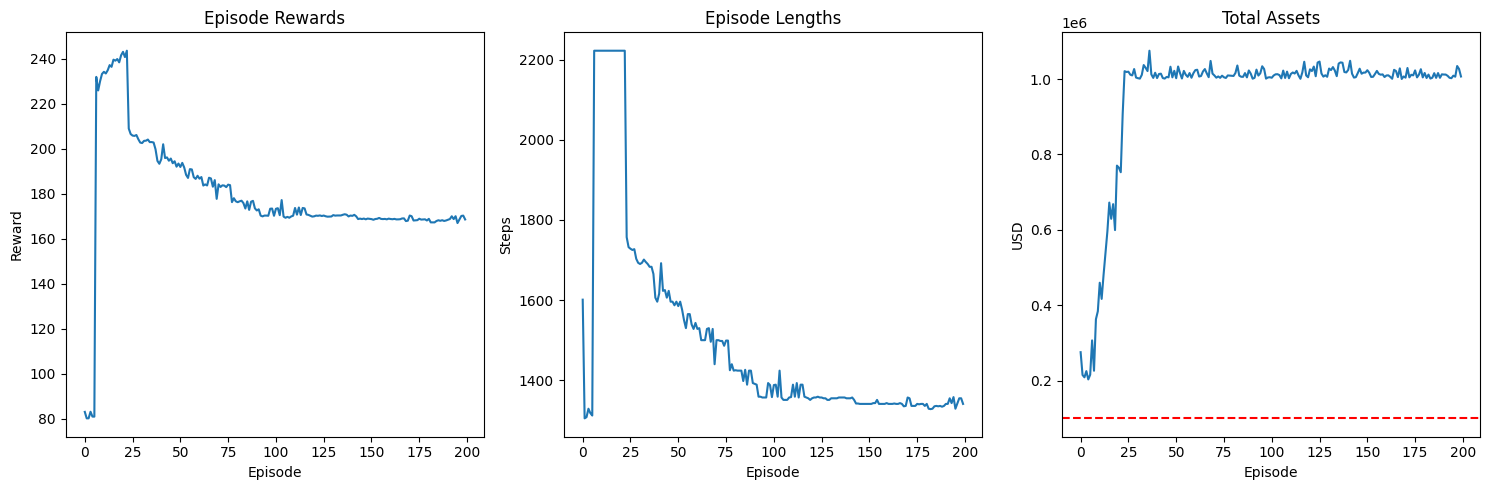

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import gym
from tqdm import tqdm
import os

# Tạo thư mục kết quả nếu chưa tồn tại
if not os.path.exists("results"):
    os.makedirs("results")

# Đọc dữ liệu
train_data = pd.read_csv('AMAT_historical_data_train.csv')
test_data = pd.read_csv('AMAT_historical_data_test.csv')

# Chuẩn bị dữ liệu
def prepare_data(df):
    # Đảm bảo định dạng đúng
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # Đặt Date làm index
    df = df.set_index('Date')
    
    # Đảm bảo có đủ các cột OHLCV
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Nếu tên cột khác, đổi tên
    col_mapping = {}
    existing_columns = df.columns.tolist()
    
    for req_col in required_columns:
        # Tìm cột tương ứng (không phân biệt hoa thường)
        for col in existing_columns:
            if col.lower() == req_col.lower():
                if col != req_col:
                    col_mapping[col] = req_col
                break
    
    # Đổi tên cột nếu cần
    if col_mapping:
        df = df.rename(columns=col_mapping)
    
    # Kiểm tra lại xem có đủ cột OHLCV không
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Thiếu các cột: {missing_columns}")
    
    # Reset index để Date là một cột bình thường
    df = df.reset_index()
    
    return df

train_data = prepare_data(train_data)
test_data = prepare_data(test_data)

# Các tham số cho môi trường
initial_capital = 100000
buy_min = 0.44
buy_max = 0.57
sell_min = 0.35
sell_max = 0.84
transaction_session = 10
transaction_penalty = 150
transaction_fee = 0.005
total_assets_min = 50000
window_size = 20

# Khởi tạo môi trường
train_env = StockEnv(
    train_data,
    initial_capital=initial_capital,
    buy_min=buy_min,
    buy_max=buy_max,
    sell_min=sell_min,
    sell_max=sell_max,
    transaction_session=transaction_session,
    transaction_penalty=transaction_penalty,
    transaction_fee=transaction_fee,
    total_assets_min=total_assets_min,
    window_size=window_size
)

# Thông số cho TD3
state_dim = train_env.observation_space.shape[0]
action_dim = train_env.action_space.shape[0]
max_action = float(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo thuật toán TD3
td3 = TD3(state_dim, action_dim, max_action, device)

# Khởi tạo Replay Buffer
replay_buffer = ReplayBuffer(max_size=100000)

# Huấn luyện
def train(env, agent, replay_buffer, max_episodes=1000, max_steps=1000, 
          batch_size=256, exploration_noise=0.1):
    
    results = {
        'episode_rewards': [],
        'episode_lengths': [],
        'total_assets': []
    }
    
    best_reward = -np.inf
    
    for episode in tqdm(range(max_episodes)):
        state = env.reset()
        episode_reward = 0
        episode_steps = 0
        episode_assets = []
        
        done = False
        while not done and episode_steps < max_steps:
            action = agent.select_action(state, noise=exploration_noise)
            next_state, reward, done, info = env.step(action)
            
            # Lưu vào replay buffer
            replay_buffer.add(state, action, reward, next_state, done)
            
            # Huấn luyện agent nếu có đủ dữ liệu
            if replay_buffer.size() > batch_size:
                agent.train(replay_buffer, batch_size)
            
            state = next_state
            episode_reward += reward
            episode_steps += 1
            episode_assets.append(info['total_assets'])
            
            # Giảm nhiễu theo thời gian
            exploration_noise *= 0.9999
            exploration_noise = max(0.05, exploration_noise)
        
        # Lưu kết quả
        results['episode_rewards'].append(episode_reward)
        results['episode_lengths'].append(episode_steps)
        results['total_assets'].append(episode_assets[-1] if episode_assets else initial_capital)
        
        # In kết quả episode
        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}: Reward = {episode_reward:.2f}, Steps = {episode_steps}, "
                  f"Final Assets = ${episode_assets[-1]:.2f}, Exploration Noise = {exploration_noise:.4f}")
        
        # Lưu model tốt nhất
        if episode_reward > best_reward:
            best_reward = episode_reward
            agent.save("results/best_model")
        
        # Lưu model định kỳ
        if (episode + 1) % 100 == 0:
            agent.save(f"results/model_ep{episode+1}")
    
    return results

# Đánh giá
def evaluate(env, agent, episodes=10, render=False):
    results = {
        'episode_rewards': [],
        'episode_lengths': [],
        'total_assets': [],
        'actions': [],
        'portfolio_values': []
    }
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        episode_steps = 0
        episode_actions = []
        portfolio_values = [env.cash_balance + env.shares_held * env.df.loc[env.current_step, 'Close']]
        
        done = False
        while not done:
            action = agent.select_action(state, noise=0)  # No noise during evaluation
            episode_actions.append(action)
            
            next_state, reward, done, info = env.step(action)
            
            if render:
                env.render()
            
            state = next_state
            episode_reward += reward
            episode_steps += 1
            portfolio_values.append(info['total_assets'])
        
        # Lưu kết quả
        results['episode_rewards'].append(episode_reward)
        results['episode_lengths'].append(episode_steps)
        results['total_assets'].append(portfolio_values[-1])
        results['actions'].append(episode_actions)
        results['portfolio_values'].append(portfolio_values)
        
        print(f"Evaluation Episode {episode+1}: Reward = {episode_reward:.2f}, "
              f"Steps = {episode_steps}, Final Assets = ${portfolio_values[-1]:.2f}")
    
    return results

# Chương trình chính
if __name__ == "__main__":
    # Tham số huấn luyện
    max_episodes = 200 
    max_steps = len(train_data) - window_size - 1
    batch_size = 256
    exploration_noise = 0.2
    
    # Huấn luyện
    print("Bắt đầu huấn luyện...")
    train_results = train(train_env, td3, replay_buffer, max_episodes, max_steps, 
                         batch_size, exploration_noise)
    
    # Lưu kết quả huấn luyện
    train_df = pd.DataFrame({
        'episode': list(range(1, len(train_results['episode_rewards']) + 1)),
        'reward': train_results['episode_rewards'],
        'steps': train_results['episode_lengths'],
        'total_assets': train_results['total_assets']
    })
    train_df.to_csv('results/training_results.csv', index=False)
    
    # Vẽ biểu đồ kết quả huấn luyện
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_results['episode_rewards'])
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    
    plt.subplot(1, 3, 2)
    plt.plot(train_results['episode_lengths'])
    plt.title('Episode Lengths')
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    
    plt.subplot(1, 3, 3)
    plt.plot(train_results['total_assets'])
    plt.axhline(y=initial_capital, color='r', linestyle='--')
    plt.title('Total Assets')
    plt.xlabel('Episode')
    plt.ylabel('USD')
    
    plt.tight_layout()
    plt.savefig('results/training_plots.png')
    
    # Tạo môi trường đánh giá với dữ liệu kiểm thử
    test_env = StockEnv(
        test_data,
        initial_capital=initial_capital,
        buy_min=buy_min,
        buy_max=buy_max,
        sell_min=sell_min,
        sell_max=sell_max,
        transaction_session=transaction_session,
        transaction_penalty=transaction_penalty,
        transaction_fee=transaction_fee,
        total_assets_min=total_assets_min,
        window_size=window_size
    )
    
    # Tải model tốt nhất
    td3.load("results/best_model")
    
    # Đánh giá trên dữ liệu kiểm thử
    print("\nĐánh giá model trên dữ liệu kiểm thử...")

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
C:\Users\Admin\AppData\Local\Temp\ipykernel_14556\3112384337.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setti

Bắt đầu kiểm thử mô hình TD3 trên dữ liệu kiểm thử...
Day 0, Action Buy(1.00), Asset 99715.00, Reward 0.1000
Day 1, Action Buy(1.00), Asset 102094.37, Reward 0.3386
Day 2, Action Buy(1.00), Asset 99162.01, Reward -0.1872
Day 3, Action Buy(1.00), Asset 97398.45, Reward -0.0778
Day 4, Action Buy(1.00), Asset 99648.56, Reward 0.3310
Day 5, Action Buy(0.83), Asset 95921.71, Reward -0.2740
Day 6, Action Buy(1.00), Asset 96026.62, Reward 0.1109
Day 7, Action Buy(0.07), Asset 94945.51, Reward -0.0126
Day 8, Action Buy(0.94), Asset 96398.65, Reward 0.2530
Day 9, Action Buy(1.00), Asset 97977.36, Reward 0.2638
Day 10, Action Buy(1.00), Asset 98820.80, Reward 0.1861
Day 11, Action Buy(1.00), Asset 95454.37, Reward -0.2407
Day 12, Action Buy(0.99), Asset 95495.71, Reward 0.1043
Day 13, Action Buy(1.00), Asset 92054.51, Reward -0.2604
Day 14, Action Buy(0.00), Asset 91334.82, Reward 0.0218
Day 15, Action Buy(0.00), Asset 93402.89, Reward 0.3264
Day 16, Action Buy(1.00), Asset 92079.32, Reward -0.0

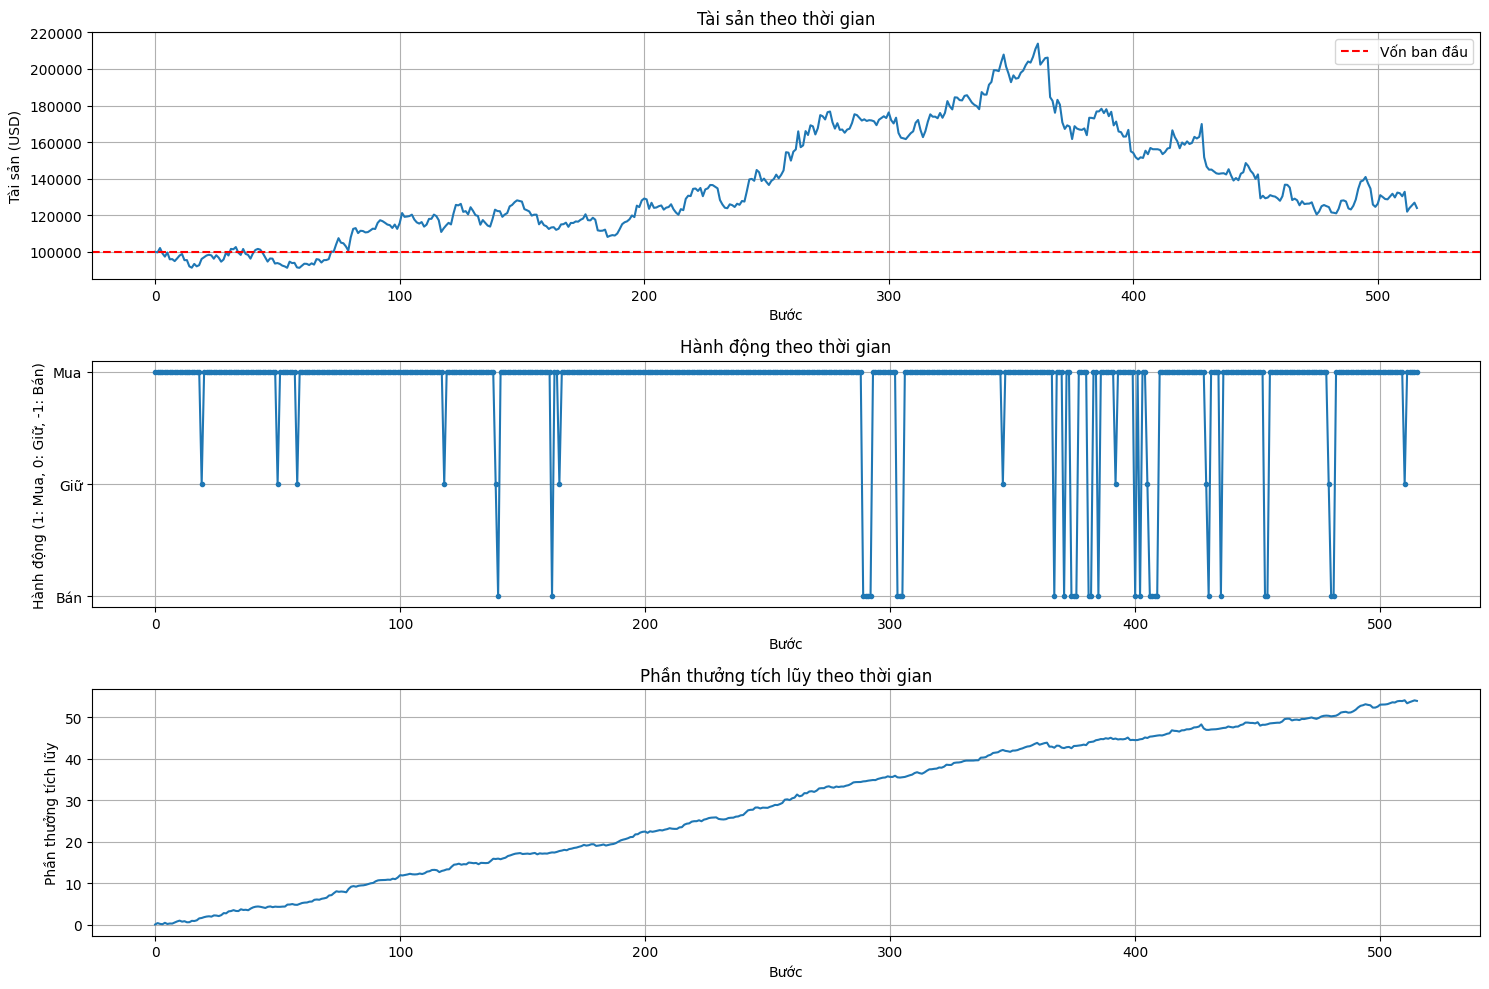

In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Đọc dữ liệu kiểm thử
test_data = pd.read_csv('AMAT_historical_data_test.csv')

# Chuẩn bị dữ liệu
def prepare_data(df):
    # Đảm bảo định dạng đúng
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # Đặt Date làm index tạm thời để xử lý
    df = df.set_index('Date')
    
    # Đảm bảo có đủ các cột OHLCV
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
    # Nếu tên cột khác, đổi tên
    col_mapping = {}
    existing_columns = df.columns.tolist()
    
    for req_col in required_columns:
        # Tìm cột tương ứng (không phân biệt hoa thường)
        for col in existing_columns:
            if col.lower() == req_col.lower():
                if col != req_col:
                    col_mapping[col] = req_col
                break
    
    # Đổi tên cột nếu cần
    if col_mapping:
        df = df.rename(columns=col_mapping)
    
    # Reset index để Date là một cột bình thường
    df = df.reset_index()
    
    return df

test_data = prepare_data(test_data)

# Các tham số cho môi trường
initial_capital = 100000
buy_min = 0.44
buy_max = 0.57
sell_min = 0.35
sell_max = 0.84
transaction_session = 10
transaction_penalty = 150
transaction_fee = 0.005
total_assets_min = 50000
window_size = 20

# Tạo môi trường kiểm thử
test_env = StockEnv(
    test_data,
    initial_capital=initial_capital,
    buy_min=buy_min,
    buy_max=buy_max,
    sell_min=sell_min,
    sell_max=sell_max,
    transaction_session=transaction_session,
    transaction_penalty=transaction_penalty,
    transaction_fee=transaction_fee,
    total_assets_min=total_assets_min,
    window_size=window_size
)

# Thông số cho TD3
state_dim = test_env.observation_space.shape[0]
action_dim = test_env.action_space.shape[0]
max_action = float(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo thuật toán TD3
td3 = TD3(state_dim, action_dim, max_action, device)

# Tải model đã huấn luyện
td3.load("results/best_model")  # Đổi đường dẫn nếu cần

# Hàm kiểm thử
def test_model(env, agent):
    state = env.reset()
    done = False
    total_reward = 0
    
    # Lưu lịch sử giao dịch
    action_history = []
    asset_history = [env.cash_balance + env.shares_held * env.df.loc[env.current_step, 'Close']]
    reward_history = []
    date_history = [env.df.loc[env.current_step, 'Date']]
    
    # Thực hiện các hành động cho đến khi kết thúc
    step = 0
    while not done:
        # Lấy hành động từ model
        action = agent.select_action(state, noise=0)  # Không thêm nhiễu khi test
        
        # Thực hiện hành động
        next_state, reward, done, info = env.step(action)
        
        # Lưu thông tin
        total_reward += reward
        action_history.append(action)
        asset_history.append(info['total_assets'])
        reward_history.append(reward)
        current_date = env.df.loc[env.current_step, 'Date'] if env.current_step < len(env.df) else "End"
        date_history.append(current_date)
        
        # In thông tin theo định dạng yêu cầu
        # Convert action array to readable format
        action_type = "Buy" if action[0] > 0.3 else ("Sell" if action[0] < -0.3 else "Hold")
        action_ratio = action[1]
        action_description = f"{action_type}({action_ratio:.2f})"
        
        print(f"Day {step}, Action {action_description}, Asset {info['total_assets']:.2f}, Reward {reward:.4f}")
        
        # Cập nhật trạng thái
        state = next_state
        step += 1
    
    # Tính lợi nhuận cuối cùng
    final_asset = asset_history[-1]
    profit = final_asset - initial_capital
    profit_percentage = (profit / initial_capital) * 100
    
    print("\n===== KẾT QUẢ KIỂM THỬ =====")
    print(f"Tổng số bước: {step}")
    print(f"Tài sản ban đầu: ${initial_capital:.2f}")
    print(f"Tài sản cuối cùng: ${final_asset:.2f}")
    print(f"Lợi nhuận: ${profit:.2f} ({profit_percentage:.2f}%)")
    print(f"Tổng reward: {total_reward:.2f}")
    
    # Vẽ biểu đồ kết quả
    plot_results(date_history, asset_history, action_history, reward_history)
    
    return {
        'steps': step,
        'initial_capital': initial_capital,
        'final_asset': final_asset,
        'profit': profit,
        'profit_percentage': profit_percentage,
        'total_reward': total_reward,
        'date_history': date_history,
        'asset_history': asset_history,
        'action_history': action_history,
        'reward_history': reward_history
    }

# Hàm vẽ biểu đồ kết quả
def plot_results(dates, assets, actions, rewards):
    # Tạo thư mục kết quả nếu chưa tồn tại
    if not os.path.exists("results"):
        os.makedirs("results")
    
    # Chuyển đổi hành động thành loại (mua/bán/giữ)
    action_types = []
    for action in actions:
        if action[0] > 0.3:
            action_types.append(1)  # Mua
        elif action[0] < -0.3:
            action_types.append(-1)  # Bán
        else:
            action_types.append(0)  # Giữ
    
    # Biểu đồ tài sản
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(assets)
    plt.axhline(y=initial_capital, color='r', linestyle='--', label='Vốn ban đầu')
    plt.title('Tài sản theo thời gian')
    plt.xlabel('Bước')
    plt.ylabel('Tài sản (USD)')
    plt.legend()
    plt.grid(True)
    
    # Biểu đồ hành động
    plt.subplot(3, 1, 2)
    plt.plot(action_types, marker='o', linestyle='-', markersize=3)
    plt.title('Hành động theo thời gian')
    plt.xlabel('Bước')
    plt.ylabel('Hành động (1: Mua, 0: Giữ, -1: Bán)')
    plt.yticks([-1, 0, 1], ['Bán', 'Giữ', 'Mua'])
    plt.grid(True)
    
    # Biểu đồ phần thưởng tích lũy
    plt.subplot(3, 1, 3)
    cumulative_rewards = np.cumsum(rewards)
    plt.plot(cumulative_rewards)
    plt.title('Phần thưởng tích lũy theo thời gian')
    plt.xlabel('Bước')
    plt.ylabel('Phần thưởng tích lũy')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('results/test_results.png')
    
    # Lưu dữ liệu kết quả
    result_df = pd.DataFrame({
        'Date': dates[1:],  # Bỏ phần tử đầu tiên vì không có hành động tương ứng
        'Asset': assets[1:],
        'Action_Type': action_types,
        'Action_Ratio': [action[1] for action in actions],
        'Reward': rewards
    })
    result_df.to_csv('results/test_detailed_results.csv', index=False)

# Thực hiện kiểm thử
if __name__ == "__main__":
    print("Bắt đầu kiểm thử mô hình TD3 trên dữ liệu kiểm thử...")
    test_results = test_model(test_env, td3)
    
    # Lưu kết quả tổng quan
    summary_df = pd.DataFrame({
        'Metric': ['Steps', 'Initial Capital', 'Final Asset', 'Profit', 'Profit Percentage', 'Total Reward'],
        'Value': [
            test_results['steps'],
            f"${test_results['initial_capital']:.2f}",
            f"${test_results['final_asset']:.2f}",
            f"${test_results['profit']:.2f}",
            f"{test_results['profit_percentage']:.2f}%",
            f"{test_results['total_reward']:.2f}"
        ]
    })
    summary_df.to_csv('results/test_summary.csv', index=False)
    
    print("\nKết quả đã được lưu vào thư mục 'results'")